In [1]:
import sys
import subprocess
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seismic-library/')
import kaggle_support as kgs
import importlib
import time
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import copy
import seis_forward2

In [2]:
data = kgs.load_all_train_data(validation_only=True) + kgs.load_all_test_data()
data = data

In [3]:
folder = kgs.cache_dir_read + '/Style_B/'
#files_default = glob.glob(folder + '/*')
#files_default = ([os.path.basename(f) for f in files_default])
#files_default = set(files_default)
files_todo = ([os.path.basename(f) for f in glob.glob(folder + '/*')])
files_todo = set(files_todo)

In [4]:
def get_data_from_file(f):
    data = kgs.dill_load(f)[0]
    return data
res = dict()
res['cache_name'], res['is_train'], res['update_mae'], res['score_brendan'], res['score'], res['seis_err_rms'], res['seis_err_rms_brendan'] = [],[],[],[],[],[],[]
for d in tqdm(data):
    f = d.cache_name()
    if f in files_todo:
        vel_default = get_data_from_file(folder +f)
        vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
        res['cache_name'].append(f)
        res['is_train'].append(d.is_train)
        res['update_mae'].append(np.mean(np.abs(vel_default.data-vel_brendan.data)))
        if d.is_train:
            d.velocity.load_to_memory()
            res['score'].append(np.mean(np.abs(vel_default.data-cp.asnumpy(d.velocity.data))))
            res['score_brendan'].append(np.mean(np.abs(vel_brendan.data-cp.asnumpy(d.velocity.data))))
            d.velocity.unload()
        else:
            res['score'].append(np.nan)
            res['score_brendan'].append(np.nan)
            
        vel = copy.deepcopy(vel_default)
        vel.to_cupy()
        vel.data = vel.data.astype(cp.float64)
        vel.min_vel = vel.min_vel.astype(cp.float64)
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())

        vel = copy.deepcopy(vel_brendan)
        vel.to_cupy()
        vel.data = vel.data.astype(cp.float64)
        vel.min_vel = vel.min_vel.astype(cp.float64)
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms_brendan'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())
        
        d.seismogram.unload()
df = pd.DataFrame(res)
tr = df['is_train']
ntr = np.logical_not(df['is_train'])

  0%|                                                                                        | 0/70818 [00:00<?, ?it/s]

capturing graph


100%|████████████████████████████████████████████████████████████████████████████| 70818/70818 [13:48<00:00, 85.47it/s]


In [5]:
np.sum(df['is_train']), np.sum(np.logical_not(df['is_train']))

(250, 6337)

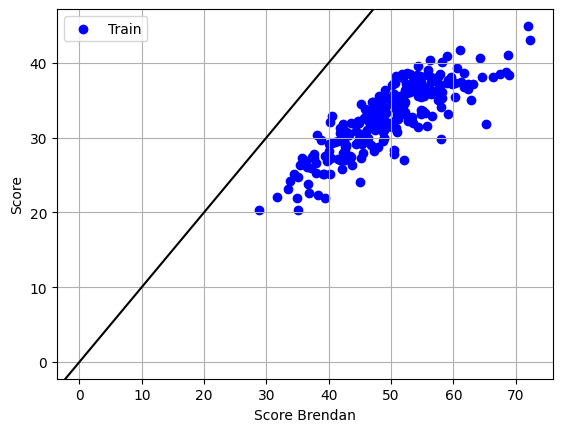

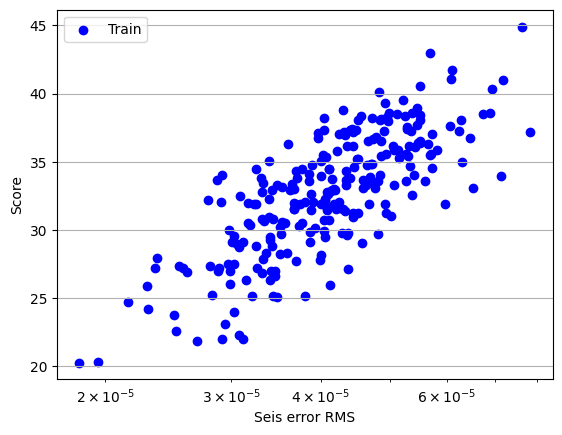

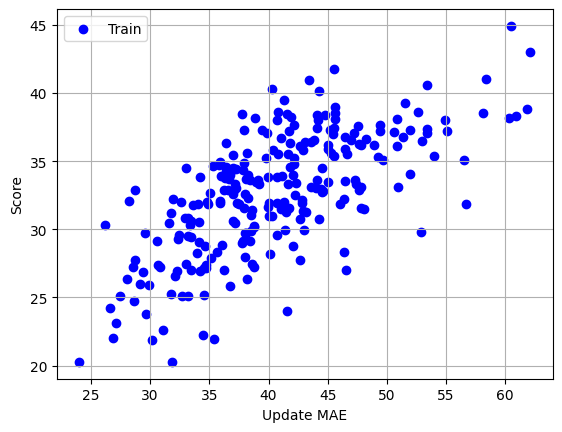

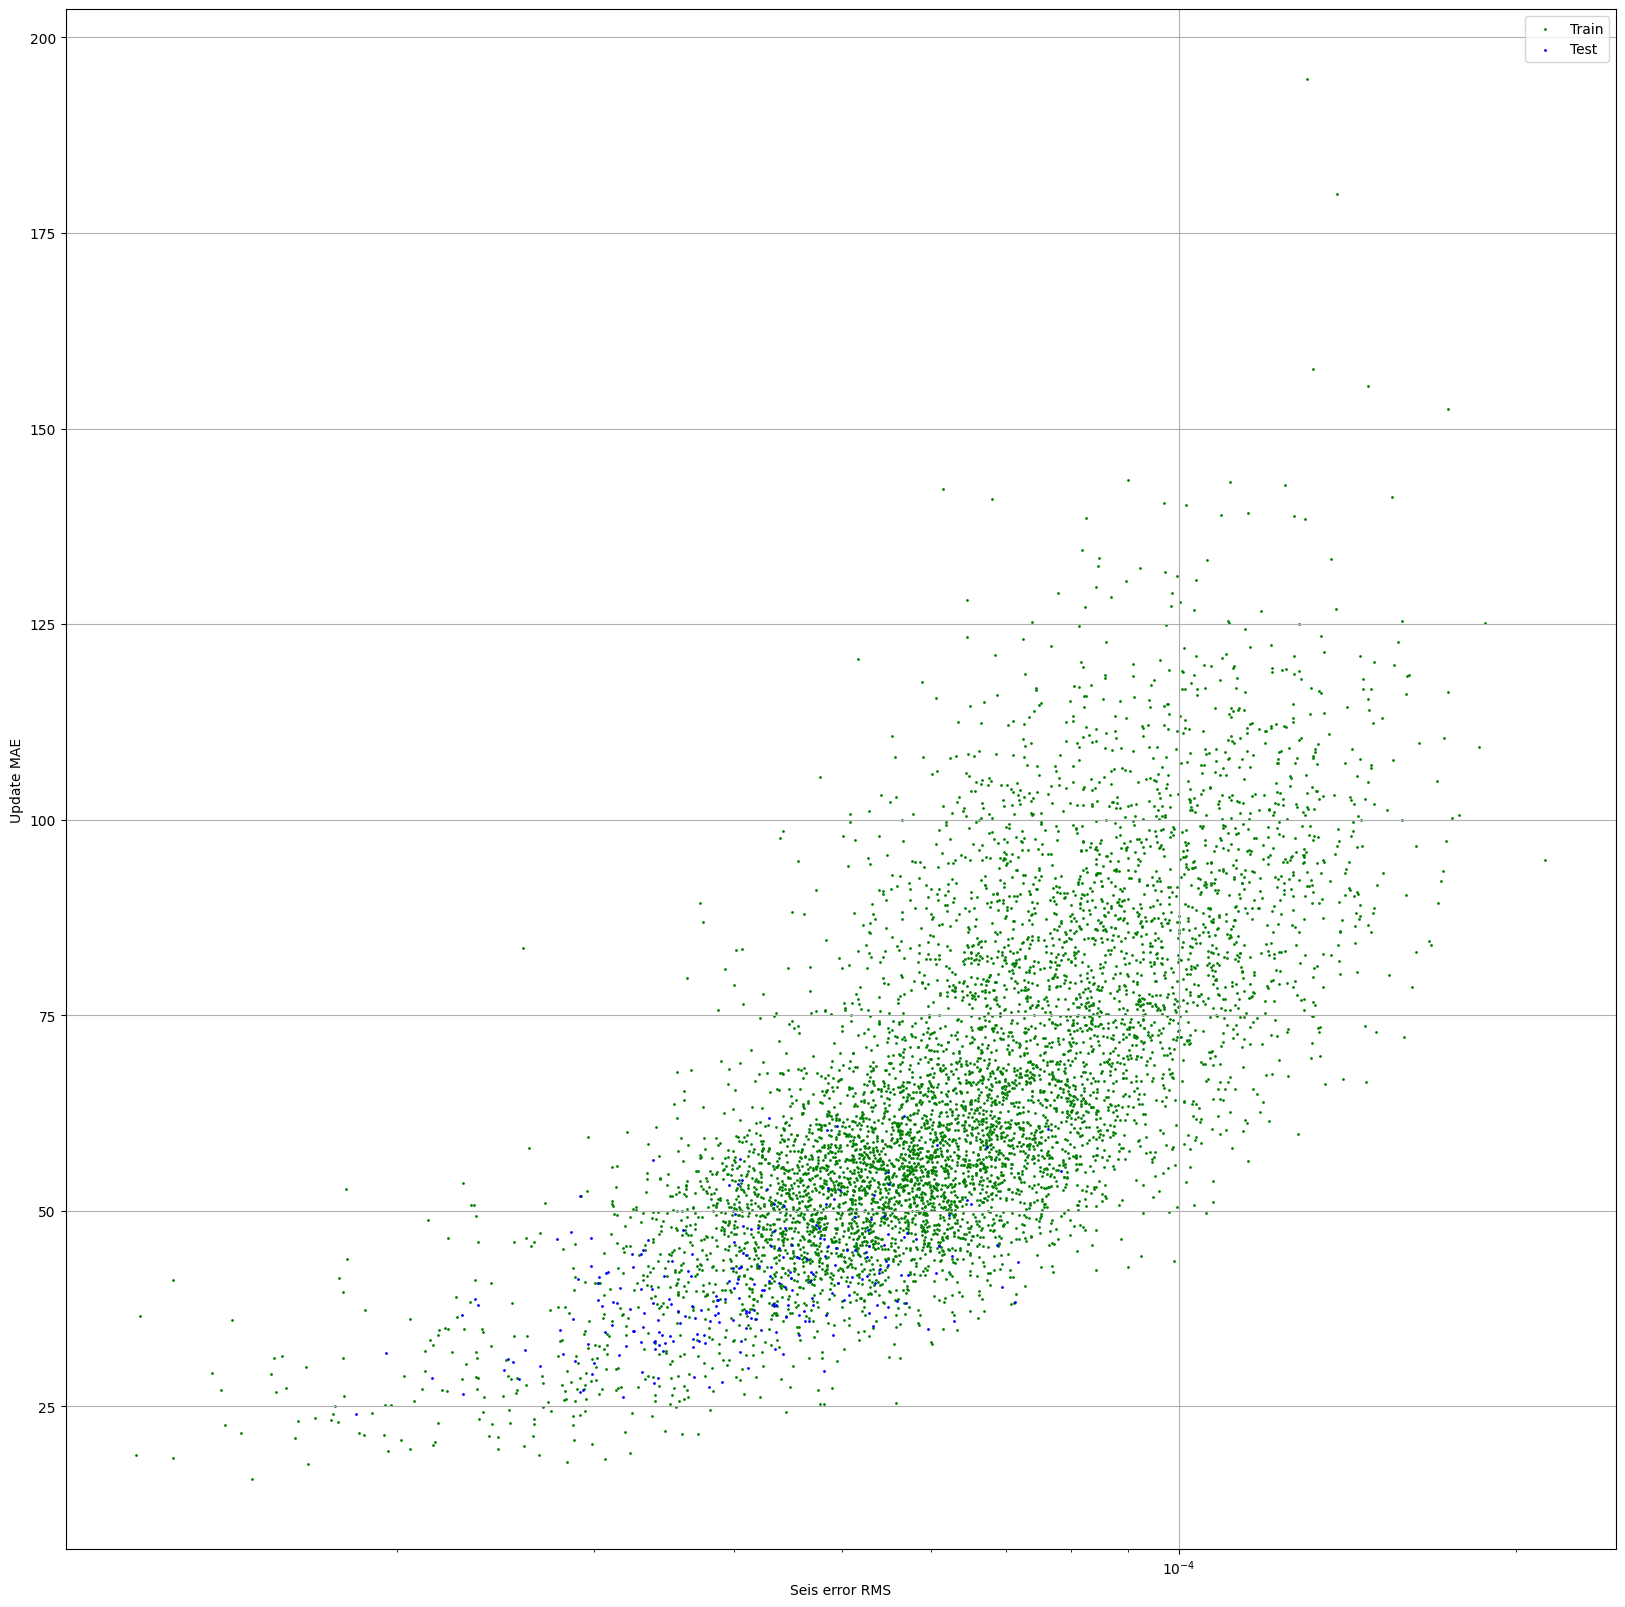

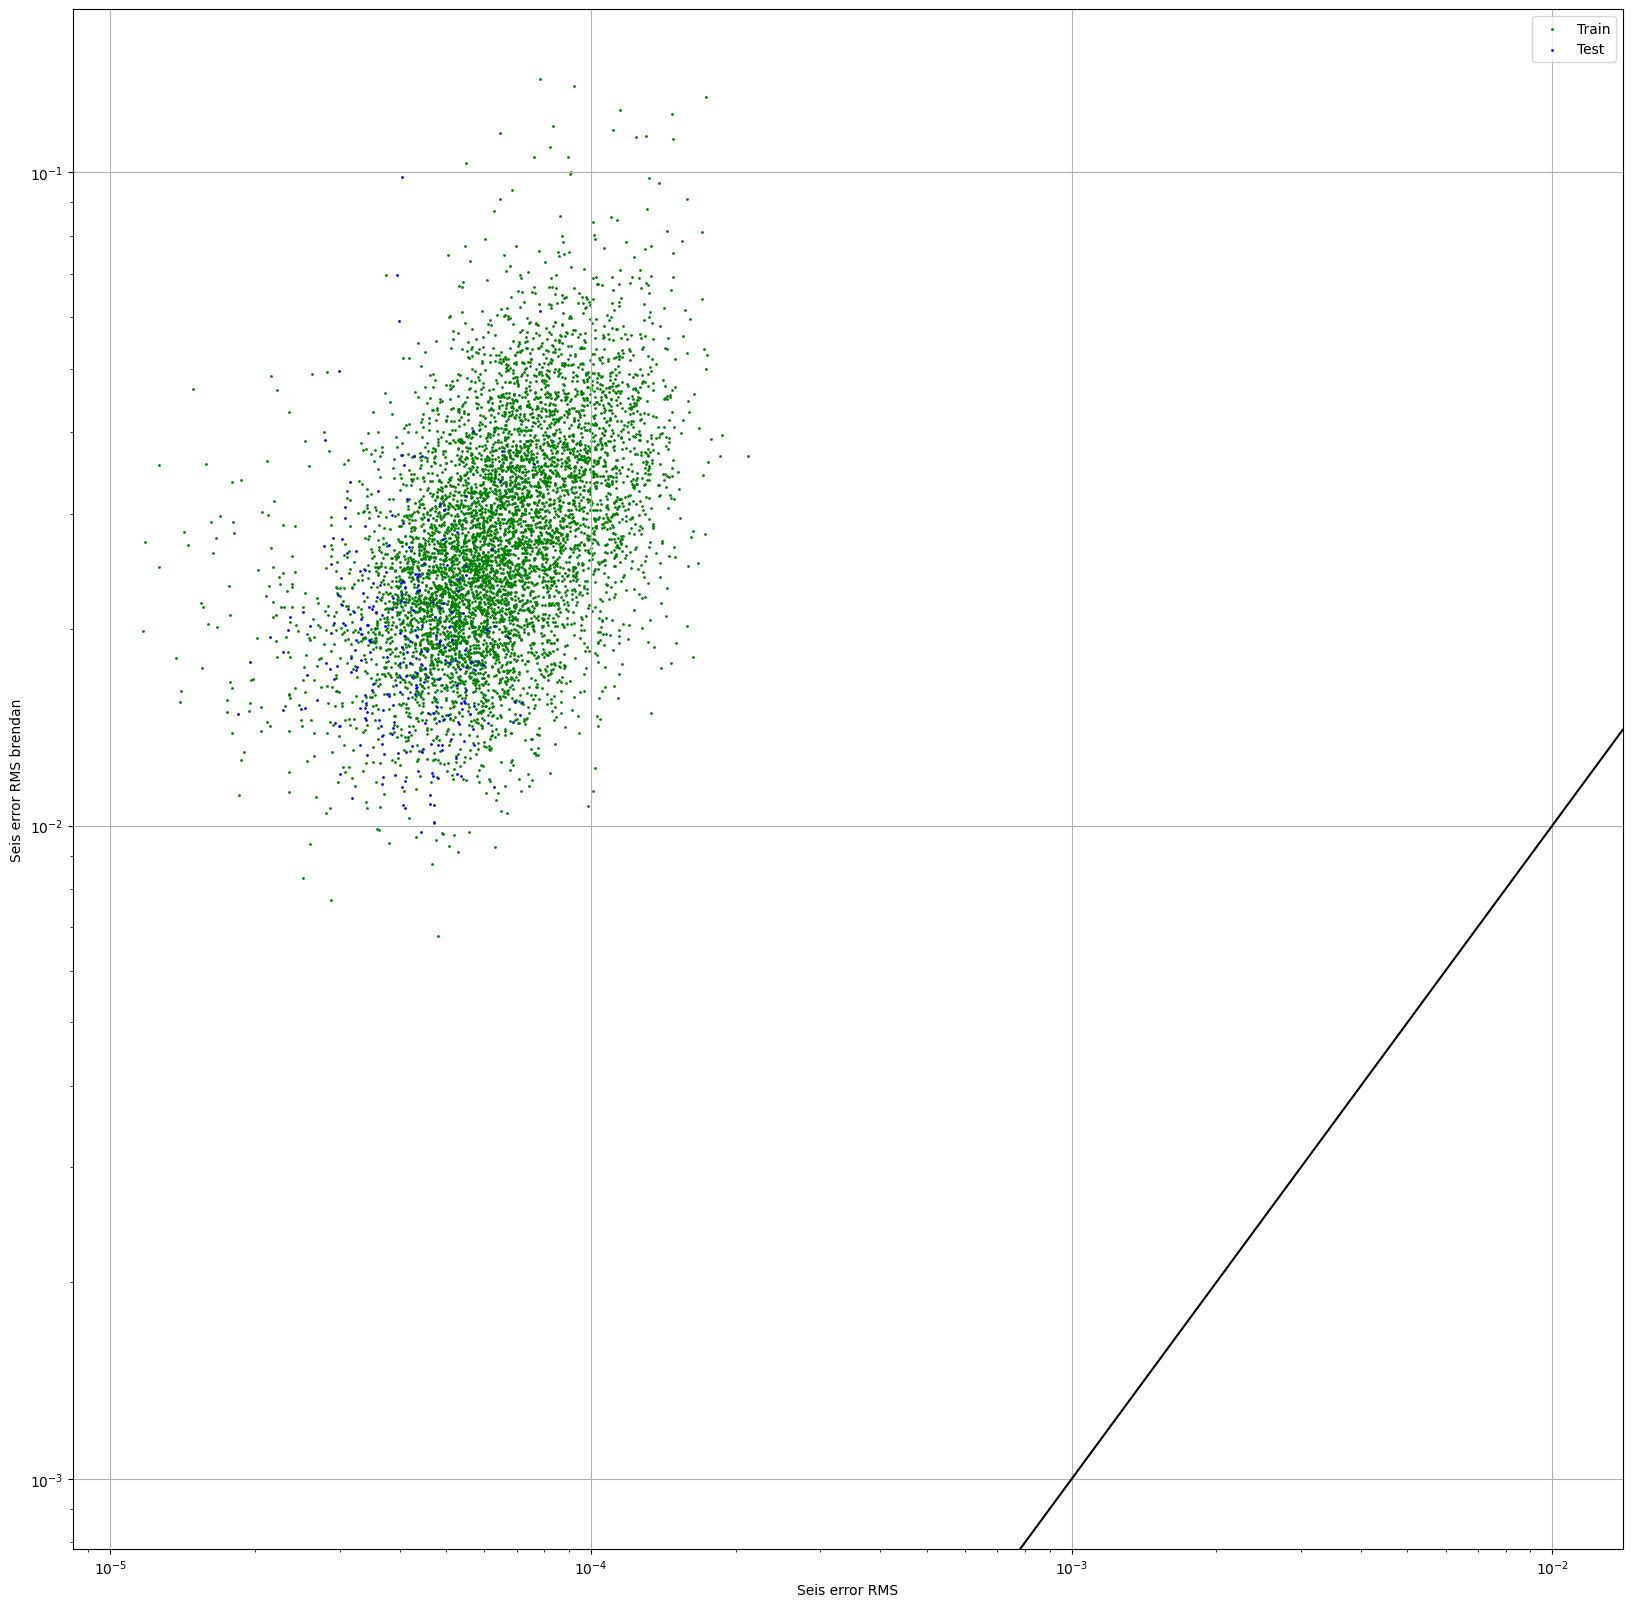

In [6]:
plt.figure();plt.scatter(df[tr]['score_brendan'],df[tr]['score'],color='blue');plt.xlabel('Score Brendan');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.axline((1e-3,1e-3),(1e-2,1e-2),color='black')
plt.figure();plt.scatter(df[tr]['seis_err_rms'],df[tr]['score'],color='blue');plt.xlabel('Seis error RMS');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.xscale('log');
plt.figure();plt.scatter(df[tr]['update_mae'],df[tr]['score'],color='blue');plt.xlabel('Update MAE');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);

plt.figure(figsize=(20,20));plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['update_mae'],1,color='green');plt.scatter(df[tr]['seis_err_rms'],df[tr]['update_mae'],1,color='blue');
plt.xlabel('Seis error RMS');plt.ylabel('Update MAE');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');

plt.figure(figsize=(20,20));plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['seis_err_rms_brendan'],1,color='green');plt.scatter(df[tr]['seis_err_rms'],df[tr]['seis_err_rms_brendan'],1,color='blue');
plt.xlabel('Seis error RMS');plt.ylabel('Seis error RMS brendan');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');plt.yscale('log');
plt.axline((1e-3,1e-3),(1e-2,1e-2),color='black')

(array(7.83981361e-05), array(0.00021235))

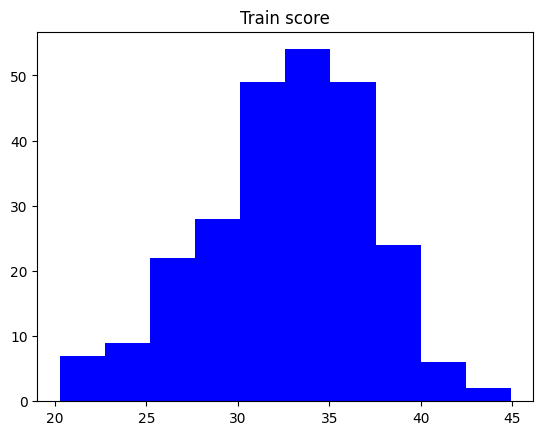

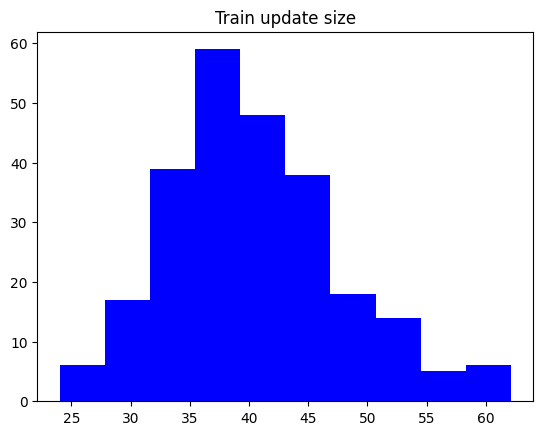

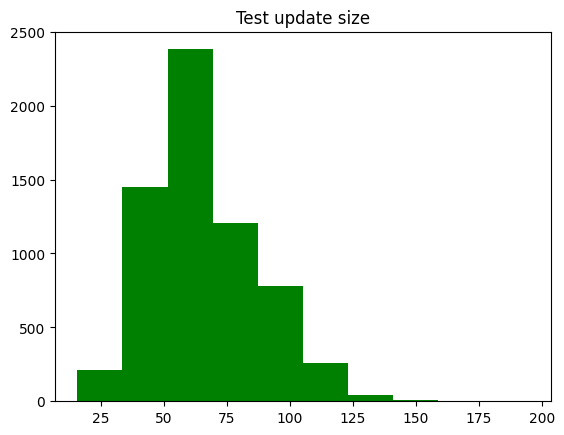

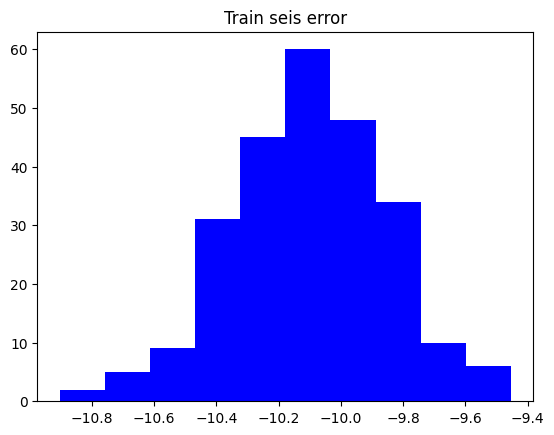

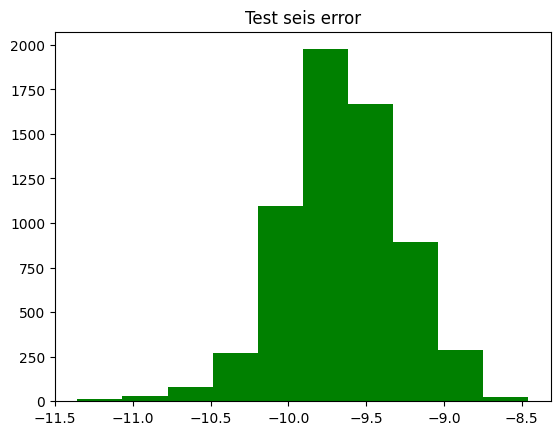

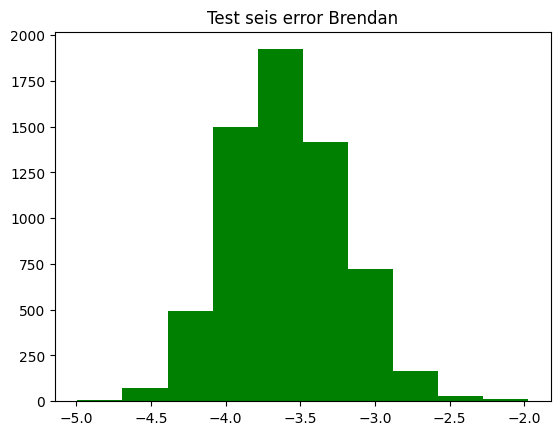

In [7]:
plt.figure();plt.hist(df[df['is_train']]['score'], color='blue');plt.title('Train score')
plt.figure();plt.hist(df[df['is_train']]['update_mae'], color='blue');plt.title('Train update size')
plt.figure();plt.hist(df[np.logical_not(df['is_train'])]['update_mae'], color='green');plt.title('Test update size')
plt.figure();plt.hist(np.log(np.array(list(df[df['is_train']]['seis_err_rms'].to_numpy()))), color='blue');plt.title('Train seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms'].to_numpy()))), color='green');plt.title('Test seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms_brendan'].to_numpy()))), color='green');plt.title('Test seis error Brendan')
np.max(df[tr]['seis_err_rms']), np.max(df[ntr]['seis_err_rms'])

In [8]:
# for _,row in df.iterrows():
#     if row['seis_err_rms']>2e-4:
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_brendan.data);plt.title('NN prediction');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_default.data-vel_brendan.data);plt.title('Update');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)
#     if (row['is_train'] and row['score']>0.5):
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 d.load_to_memory()
#                 vel_correct = d.velocity
#                 vel_correct.data = vel_correct.data.get()
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_correct.data);plt.title('Correct');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data-vel_correct.data);plt.title('Error');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)

In [9]:
400*50/65000

0.3076923076923077

In [10]:
df2 = df[tr].sort_values('seis_err_rms', ascending=False)
df2

,cache_name,is_train,update_mae,score_brendan,score,seis_err_rms,seis_err_rms_brendan
188,data1__Style_B__376,True,55.078311,62.328757,37.194834,7.83981361069365e-05,0.06145779194170164
157,data1__Style_B__314,True,60.459100,71.931102,44.918423,7.626676890161846e-05,0.035773728269148077
216,data1__Style_B__432,True,43.456679,58.968321,40.964142,7.17305498458125e-05,0.015487894835099249
187,data1__Style_B__374,True,38.301720,48.964153,33.972459,7.131607985158592e-05,0.01479338862350161
8,data1__Style_B__16,True,40.336740,56.171914,40.324762,6.939497586705296e-05,0.01545332152178454
...,...,...,...,...,...,...,...
120,data1__Style_B__240,True,26.599199,33.852749,24.200757,2.2903422517358964e-05,0.015063535943927188
193,data1__Style_B__386,True,36.705993,42.089632,25.856482,2.286638649042343e-05,0.01846897629058235
245,data1__Style_B__490,True,28.677122,35.096020,24.747772,2.148898159786343e-05,0.019416000345570197
135,data1__Style_B__270,True,31.830748,35.045888,20.286637,1.954547188213956e-05,0.017830469415222892


In [11]:
df2 = df[ntr].sort_values('seis_err_rms', ascending=False)
df2

,cache_name,is_train,update_mae,score_brendan,score,seis_err_rms,seis_err_rms_brendan
1200,26d2a1994c__test__None,False,94.792983,NaN,NaN,0.00021235294911382845,0.036846430793305594
884,19eb0fde7c__test__None,False,125.170752,NaN,NaN,0.00018765713556600277,0.039655212977859455
2995,709e56eade__test__None,False,109.300089,NaN,NaN,0.000185333361849249,0.03681260474882027
4003,979c46eacc__test__None,False,100.645647,NaN,NaN,0.0001778338428378704,0.03910155008368756
1127,23cab121ce__test__None,False,100.236637,NaN,NaN,0.00017518111442513574,0.036036591183048555
...,...,...,...,...,...,...,...
4508,ab2bf1e01f__test__None,False,29.316698,NaN,NaN,1.3664623290829873e-05,0.01808514066787144
4459,a93edf49db__test__None,False,18.437182,NaN,NaN,1.2610848630149235e-05,0.02487765541453224
5026,c05ca39bc2__test__None,False,41.191082,NaN,NaN,1.2605332068788185e-05,0.03569415055160767
3161,77521fe145__test__None,False,36.547031,NaN,NaN,1.1794403499729391e-05,0.027203973076435985


In [12]:
kgs.dill_save(kgs.temp_dir + '/style_B_df.pickle', df)